# Entries

1. Historical statistics of direct confrontation (team 1 vs team 2)
2. Statistics of *N* previous matches for each team
3. Home player or away player
4. Current points on championship
5. Match day matters?

In [1]:
import sys
sys.path.append("..")

In [2]:
from pprint import pprint
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from db.database import DAO

In [3]:
dao = DAO()
matches_collection = dao.matches()

In [4]:
# Sample match for testing
sample = matches_collection.find_one()
pprint(sample)

{'_id': ObjectId('5ac952926b5b9e2af46c59ef'),
 'arbiter': 'Leonardo Gaciba da Silva',
 'away_team': 'Santos',
 'cards': [{'player': 'Alex Sandro', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Zé Eduardo', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Herrera', 'team': 'BOT', 'type': 'yellow'},
           {'player': 'Wesley', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Alex Sandro', 'team': 'SAN', 'type': 'red'}],
 'coaches': {'away_team': 'Dorival Júnior', 'home_team': 'Joel Santana'},
 'home_team': 'Botafogo',
 'location': {'city': 'Brasil, Rio de Janeiro, RJ', 'stadium': 'Engenhão'},
 'players': {'away_team': [{'name': 'Felipe Garcia', 'position': 'GOL'},
                           {'name': 'Bruno Aguiar', 'position': 'ZAD'},
                           {'name': 'Durval', 'position': 'ZAE'},
                           {'name': 'Maranhão', 'position': 'LAD'},
                           {'name': 'Alex Sandro', 'position': 'LAE'},
                     

## Match Vectorizer
Takes a match in the above format and extracts the most important characteristics in the following order:

<ol>
- Current match statistics
<li> Home team score </li>
<li> Away team score </li>

- Statistics of all confronts of the teams
<li> Goals by home team </li>
<li> Goals by away team </li>
<li> Number of victories of home team </li>
<li> Number o victories of away team </li>
<li> Number of draws </li>

- Statistics of N previous games of each team
<li> Balance of N last games of home team </li>
<li> Balance of N last games of away team </li>
</ol>

In [5]:
# Default match feature extractor. ht is home_team and at is away_team
N = 4
labels = ['ht_score', 'at_score', 'goals_ht', 'goals_at', 'wins_ht', 'wins_at', 'draws', 
          *(['sg_ht']*N), *(['sg_at']*N)]
def vectorize_match(dao, match, N):
    stats = match['statistics']
    score = match['score']
    home_team_last_sg = dao.get_last_N_balances(match['home_team'], N)
    away_team_last_sg = dao.get_last_N_balances(match['away_team'], N)
    return [
            score['home_team'],
            score['away_team'], 
            stats['goals_home_team'], 
            stats['goals_away_team'],
            stats['wins_home_team'], 
            stats['wins_away_team'], 
            stats['previous_draws'], 
            *home_team_last_sg, 
            *away_team_last_sg
           ]

In [6]:
# Vectorize matches from 2016
matches = matches_collection.find({'year':2016})
data = [vectorize_match(dao, match, N) for match in matches]
data = pd.DataFrame(data=data, columns=labels)
data.head()

,ht_score,at_score,goals_ht,goals_at,wins_ht,wins_at,draws,sg_ht,sg_ht,sg_ht,sg_ht,sg_at,sg_at,sg_at,sg_at
0,4,0,50,39,15,8,13,-1,1,1,0,-2,-1,2,0
1,1,0,48,35,16,9,8,-1,0,2,-2,-1,0,-2,-1
2,1,0,92,80,25,19,17,2,-2,0,0,1,1,-2,2
3,1,0,48,62,10,17,12,0,-1,-1,0,0,1,1,1
4,0,1,72,97,21,26,13,-1,1,2,2,1,0,1,0


In [23]:
# Splitting X and Y
Y = data.iloc[:,:2]
X = data.iloc[:,2:]
Y.head() # Y.values to extract the matrix from dataframe

,ht_score,at_score
0,4,0
1,1,0
2,1,0
3,1,0
4,0,1


In [24]:
# Feature Scaling
from sklearn.preprocessing import RobustScaler
xscaler = RobustScaler()
yscaler = RobustScaler()
X = xscaler.fit_transform(X)
Y = yscaler.fit_transform(Y)

### Splitting training and test sets
- Training set size: 80%
- Testing set size: 20%
- Temporal order maintained (random_state=0)

In [25]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Building the Perceptron ANN
- Input layer size: 13 (see match vectorizer for description)
- Output layer size: 2

### Task 1: Train/Test

In [26]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense

In [72]:
# Creating the neural network
metrics = ['mean_absolute_error', 'binary_accuracy']
model = Sequential()
model.add(Dense(8, input_dim=len(X_train[0]), activation='tanh'))
model.add(Dense(2, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=metrics)

### Statistics for different activation functions
With MSE loss and SGD optimizer


Activation| MAE | Binary accuracy
--- | --- | ---
linear + linear| 65.65 | **46.05**
relu + linear | 76.02 | 46.05
linear + relu | problema min=1|
linear + sigmoid | 66.79 | 40.13
sigmoid | 67.77 | 40.13
sigmoid + relu | 71.32 | 36.18
sigmoid + linear | 67.90 | 42.11
linear + tanh | |
relu + tanh | |

In [73]:
# Training
history = model.fit(X_train, Y_train, epochs=200, batch_size=10, verbose=1)#, validation_split=0.1)
scores = model.evaluate(X_test, Y_test, verbose=0)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("\n%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))

Epoch 1/200
303/303 [==============================] - 0s 2ms/step - loss: 1.2763 - mean_absolute_error: 0.8505 - binary_accuracy: 0.2855
Epoch 2/200
303/303 [==============================] - 0s 212us/step - loss: 1.1433 - mean_absolute_error: 0.8098 - binary_accuracy: 0.3102
Epoch 3/200
303/303 [==============================] - 0s 244us/step - loss: 1.0781 - mean_absolute_error: 0.7910 - binary_accuracy: 0.3168
Epoch 4/200
303/303 [==============================] - 0s 227us/step - loss: 1.0341 - mean_absolute_error: 0.7789 - binary_accuracy: 0.3234
Epoch 5/200
303/303 [==============================] - 0s 223us/step - loss: 1.0061 - mean_absolute_error: 0.7735 - binary_accuracy: 0.3185
Epoch 6/200
303/303 [==============================] - 0s 240us/step - loss: 0.9848 - mean_absolute_error: 0.7662 - binary_accuracy: 0.3086
Epoch 7/200
303/303 [==============================] - 0s 195us/step - loss: 0.9703 - mean_absolute_error: 0.7629 - binary_accuracy: 0.3069
Epoch 8/200
303/303 [=

303/303 [==============================] - 0s 229us/step - loss: 0.8651 - mean_absolute_error: 0.7141 - binary_accuracy: 0.3168
Epoch 60/200
303/303 [==============================] - 0s 227us/step - loss: 0.8645 - mean_absolute_error: 0.7137 - binary_accuracy: 0.3185
Epoch 61/200
303/303 [==============================] - 0s 236us/step - loss: 0.8629 - mean_absolute_error: 0.7140 - binary_accuracy: 0.3185
Epoch 62/200
303/303 [==============================] - 0s 236us/step - loss: 0.8632 - mean_absolute_error: 0.7133 - binary_accuracy: 0.3168
Epoch 63/200
303/303 [==============================] - 0s 238us/step - loss: 0.8614 - mean_absolute_error: 0.7121 - binary_accuracy: 0.3201
Epoch 64/200
303/303 [==============================] - 0s 215us/step - loss: 0.8617 - mean_absolute_error: 0.7141 - binary_accuracy: 0.3185
Epoch 65/200
303/303 [==============================] - 0s 259us/step - loss: 0.8608 - mean_absolute_error: 0.7132 - binary_accuracy: 0.3218
Epoch 66/200
303/303 [====

303/303 [==============================] - 0s 230us/step - loss: 0.8293 - mean_absolute_error: 0.6996 - binary_accuracy: 0.3234
Epoch 118/200
303/303 [==============================] - 0s 216us/step - loss: 0.8284 - mean_absolute_error: 0.6992 - binary_accuracy: 0.3267
Epoch 119/200
303/303 [==============================] - 0s 231us/step - loss: 0.8285 - mean_absolute_error: 0.6988 - binary_accuracy: 0.3251
Epoch 120/200
303/303 [==============================] - 0s 231us/step - loss: 0.8272 - mean_absolute_error: 0.6979 - binary_accuracy: 0.3201
Epoch 121/200
303/303 [==============================] - 0s 228us/step - loss: 0.8269 - mean_absolute_error: 0.6976 - binary_accuracy: 0.3251
Epoch 122/200
303/303 [==============================] - 0s 215us/step - loss: 0.8262 - mean_absolute_error: 0.6987 - binary_accuracy: 0.3218
Epoch 123/200
303/303 [==============================] - 0s 240us/step - loss: 0.8259 - mean_absolute_error: 0.6975 - binary_accuracy: 0.3251
Epoch 124/200
303/30

303/303 [==============================] - 0s 209us/step - loss: 0.7965 - mean_absolute_error: 0.6869 - binary_accuracy: 0.3317
Epoch 175/200
303/303 [==============================] - 0s 214us/step - loss: 0.7958 - mean_absolute_error: 0.6867 - binary_accuracy: 0.3350
Epoch 176/200
303/303 [==============================] - 0s 215us/step - loss: 0.7955 - mean_absolute_error: 0.6875 - binary_accuracy: 0.3350
Epoch 177/200
303/303 [==============================] - 0s 239us/step - loss: 0.7948 - mean_absolute_error: 0.6873 - binary_accuracy: 0.3350
Epoch 178/200
303/303 [==============================] - 0s 197us/step - loss: 0.7941 - mean_absolute_error: 0.6854 - binary_accuracy: 0.3317
Epoch 179/200
303/303 [==============================] - 0s 219us/step - loss: 0.7935 - mean_absolute_error: 0.6876 - binary_accuracy: 0.3350
Epoch 180/200
303/303 [==============================] - 0s 211us/step - loss: 0.7934 - mean_absolute_error: 0.6872 - binary_accuracy: 0.3333
Epoch 181/200
303/30

Text(0.5,1,'Binary accuracy history')

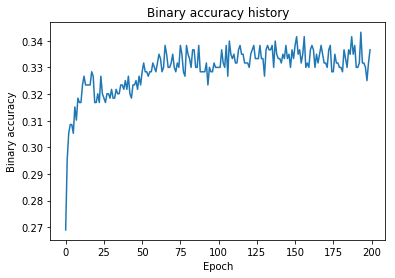

In [47]:
plt.plot(history.history['binary_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Binary accuracy')
plt.title('Binary accuracy history')

Text(0.5,1,'Mean absolute error history')

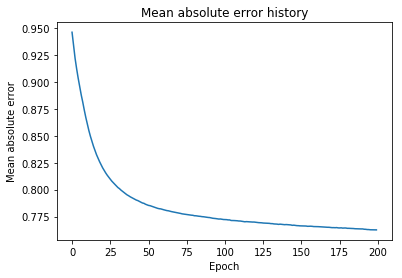

In [43]:
plt.plot(history.history['mean_absolute_error'])
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error')
plt.title('Mean absolute error history')

Text(0.5,1,'Loss history')

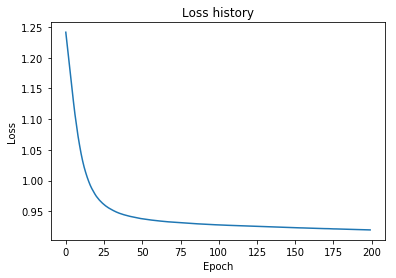

In [44]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')

In [38]:
evaluation = model.evaluate(X_test, Y_test, verbose=0)
print('Mean absolute error: {}\nBinary accurracy: {}'.format(evaluation[1], evaluation[2]))
k = model.predict(X_test)
yscaler.inverse_transform(k)

Mean absolute error: 0.5855752919849596
Binary accurracy: 0.4342105247472462


array([[1.2851524 , 1.0311149 ],
       [1.9556344 , 0.6937151 ],
       [1.6908388 , 1.0624561 ],
       [1.6904433 , 0.71166813],
       [1.9128195 , 0.9513498 ],
       [1.3717345 , 0.9173614 ],
       [1.3792686 , 0.8528147 ],
       [1.7637413 , 0.74365103],
       [1.8239022 , 0.8533005 ],
       [1.3589255 , 1.1295726 ],
       [1.7410238 , 0.9123428 ],
       [1.3015101 , 0.9532696 ],
       [1.5899189 , 0.99495304],
       [2.0926766 , 0.6750211 ],
       [1.4126527 , 0.98456347],
       [1.3552105 , 1.2559612 ],
       [1.6641003 , 1.0149192 ],
       [1.3553488 , 1.1614758 ],
       [1.6743379 , 0.76355875],
       [1.345051  , 1.1135205 ],
       [1.3039591 , 1.0318944 ],
       [1.7635744 , 0.7743324 ],
       [1.2791991 , 0.80536485],
       [1.7153919 , 0.71430886],
       [1.9858476 , 0.5043016 ],
       [1.5023811 , 0.85128844],
       [1.4036583 , 0.97349   ],
       [1.298933  , 1.0078247 ],
       [1.4704568 , 0.9107841 ],
       [1.593369  , 1.1940858 ],
       [1.

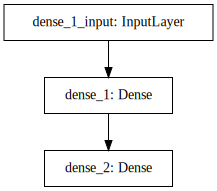

In [17]:
# Network architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))